In [2]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
import matplotlib.patheffects as pe
from copy import deepcopy


In [3]:
def get_modflow_exe(modflow_path):
    """Ensure MODFLOW executable is available in modflow_path."""
    if not os.path.exists(modflow_path):
        print("Creating MODFLOW directory and downloading executable...")
        from flopy.utils import get_modflow
        os.makedirs(modflow_path, exist_ok=True)
        get_modflow(modflow_path)
    else:
        # If directory exists but mf2005 isn't there, fetch it
        exe_path = os.path.join(modflow_path, "mf2005")
        if not os.path.exists(exe_path):
            print("MODFLOW directory exists but executable is missing. Downloading...")
            from flopy.utils import get_modflow
            get_modflow(modflow_path)
    print("MODFLOW executable ready.")


def check_get_PinalAMA_model(model_input_dir, zip_path="../pinal_county_model.zip"):
    """Check and unzip the Pinal AMA model if needed."""
    if os.path.exists(model_input_dir):
        print("Model files already unzipped.")
        return
    else:
        print("Unzipping the model files...")
        import zipfile
        base_dir = os.path.dirname(os.path.normpath(model_input_dir))  # "../"
        os.makedirs(base_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(base_dir)
        print("Unzip complete.")


In [4]:
# Define paths and filenames
modflow_path = "../modflow"                              # Directory to MODFLOW executable
modflow_exe_path = os.path.join(modflow_path, "mf2005")  # Path to the MODFLOW executable
model_input_dir = "../pinal_county_model/"               # Directory of original model files
nam_file = "PM_AWS2019_SS25115.nam"                      # Name of the MODFLOW namelist file

print(f"Path for the MODFLOW executable: {os.path.abspath(modflow_path)}")
print(f"Path for the model input directory: {os.path.abspath(model_input_dir)}")

# Ensure MODFLOW and Pinal AMA model files exist
get_modflow_exe(modflow_path)
check_get_PinalAMA_model(model_input_dir)

# Load the MODFLOW model using FloPy
print("Loading Pinal County model... (this may take a moment: Go drink some water!)\n")
mf = flopy.modflow.Modflow.load(
    nam_file,                   # Name of the MODFLOW namelist file
    model_ws=model_input_dir,   # Directory of model input files
    exe_name=modflow_exe_path,  # Path to MODFLOW executable
    check=False,                # Skip checks for faster loading
)

print(f"{'='*90}\nModel loaded successfully!")
print(mf)

print("Available packages:")
print(mf.get_package_list())
print("="*90)

print(f"\nModel dimensions:")
print(f"  Layers: {mf.nlay}")
print(f"  Rows: {mf.nrow}")
print(f"  Columns: {mf.ncol}")
print(f"  Total cells: {mf.nlay * mf.nrow * mf.ncol}")
print(f"  Stress periods: {mf.nper}")

Path for the MODFLOW executable: /workspaces/hwrs564a_course_materials_gretafreeman/modflow
Path for the model input directory: /workspaces/hwrs564a_course_materials_gretafreeman/pinal_county_model
Creating MODFLOW directory and downloading executable...
fetched release '23.0' info from MODFLOW-ORG/executables
downloading 'https://github.com/MODFLOW-ORG/executables/releases/download/23.0/linux.zip' to '/tmp/tmpk0yzext8/modflow_executables-23.0-linux.zip'
extracting 25 files to '/workspaces/hwrs564a_course_materials_gretafreeman/modflow'
crt (1.3.1)         mflgr (2.0.0)       mp6 (6.0.1)         vs2dt (3.3)
gridgen (1.0.02)    mflgrdbl (2.0.0)    mp7 (7.2.001)       zbud6 (6.6.3)
libmf6.so (6.6.3)   mfnwt (1.3.0)       mt3dms (5.3.0)      zonbud3 (3.01)
mf2000 (1.19.01)    mfnwtdbl (1.3.0)    mt3dusgs (1.1.0)    zonbudusg (1.5)
mf2005 (1.12.00)    mfusg (1.5)         sutra (4.0)
mf2005dbl (1.12.00) mfusgdbl (1.5)      swtv4 (4.00.05)
mf6 (6.6.3)         mfusg_gsi (2.5.0)   triangle (1.

# well locations

In [5]:
well_1 = (123, 181)
well_2 = (123, 182) 
wells = [well_1, well_2]

## Turn off wells based on selected cells

In [6]:
def turn_off_wells(mf_og: str,
            wells: list[tuple[int, int]], 
            output_dir: str):
    """
    removing the wells at given locations
    """
    mf_copy = deepcopy(mf_og)
    mf_copy.remove_package('MNWI')

    well_data_orig = mf_copy.wel.stress_period_data.data
    well_data_new = {}
    
    for sp in well_data_orig.keys():
        sp_data = well_data_orig[sp]
        for well in wells:
            mask = (sp_data['i'] == well[0]) & (sp_data['j'] == well[1])
            sp_data['flux'][mask] = [0.0]
            
        
        well_data_new[sp] = sp_data
    
    os.makedirs(output_dir, exist_ok=True)
    mf_copy.model_ws = output_dir
    mf_copy.write_input()
    
    return mf_copy

In [7]:
scenario_both_wells_off = '../scenario_both_wells_off/'
scenario_well_1_off = '../scenario_well_1_off/'
scenario_well_2_off = '../scenario_well_2_off/'
scens = [scenario_both_wells_off, scenario_well_1_off, scenario_well_2_off]

# Turn on "True" to remove new well locationsloads the pre-developed scanrio models. Off "False" skips turning off wells and loads the pre-developed scanrio models
create_scenario = False
models = []
if create_scenario:
    print("Turning off wells and Loading Pinal County model scenarios... (this may take a moment: Go drink some water!)\n")
    # scenario 1: turning off both wells 
    print(scenario_both_wells_off)
    m_02 = turn_off_wells(mf, [well_1, well_2], scenario_both_wells_off)
    # scenario 2: turning off well 1
    print(scenario_well_1_off)
    m_03 = turn_off_wells(mf, [well_1], scenario_well_1_off)
    print("scenario_well2_off")
    # scenario 3: turning off well 2
    m_04 = turn_off_wells(mf, [well_2], scenario_well_2_off)
    models = [mf, m_02, m_03, m_04]
else:
    print("Loading Pinal County model scenarios... (this may take a moment: Go drink some water!)\n")
    modflow_path = "../modflow"                              # Directory to MODFLOW executable
    modflow_exe_path = os.path.join(modflow_path, "mf2005")  # Path to the MODFLOW executable
    model_input_dir = "../pinal_county_model/"               # Directory of original model files
    nam_file = "PM_AWS2019_SS25115.nam"                      # Name of the MODFLOW namelist file

    # Load the MODFLOW model using FloPy
    for i, sc in enumerate(scens):
        print(scens[i])
        mo = flopy.modflow.Modflow.load(
            nam_file,                   # Name of the MODFLOW namelist file
            model_ws=model_input_dir,   # Directory of model input files
            exe_name=modflow_exe_path,  # Path to MODFLOW executable
            check=False,                # Skip checks for faster loading
        )
        models.append(mo)
    m_02, m_03, m_04 = models

models.insert(0, mf)
names = ["Original", "Both Wells", "Well 1", "Well 2"]


Loading Pinal County model scenarios... (this may take a moment: Go drink some water!)

../scenario_both_wells_off/
../scenario_well_1_off/
../scenario_well_2_off/


## Run the normal base model

In [8]:
run_og_model=False 
if run_og_model:
    success, buff = mf.run_model(silent=False, pause=False)
    if success:
        print("\n" + "="*60)
        print("Model run completed successfully!")
        print("="*60)
    else:
        print("\n" + "="*60)
        print("ERROR: Model run failed!")
        print("="*60)
        raise Exception("Model run failed. Check the .list file for errors.")

## running different pumping scenarios (~30 min run time)

In [ ]:
scenarios = [m_02, m_03, m_04]

run_model=True
if run_model:
    for scenario in scenarios:
        success, buff = scenario.run_model(silent=False)
        if not success:
            raise Exception(f"Model run failed for scenario: {scenario.model_ws}")

FloPy is using the following executable to run the model: ../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: PM_AWS2019_SS25115.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/12/06 23:08:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Gro

## Baseline and New Scenario Heads

In [10]:
hds_baseline = bf.HeadFile(os.path.join(model_input_dir, 'Pinal.hds'))
hds_both_off = bf.HeadFile('../scenario_both_wells_off/Pinal.hds')
hds_well1_off = bf.HeadFile('../scenario_well_1_off/Pinal.hds')
hds_well2_off = bf.HeadFile('../scenario_well_2_off/Pinal.hds')

heads = [hds_baseline, hds_both_off, hds_well1_off, hds_well2_off]

times = hds_baseline.get_times()
print(f"  Time steps: {len(times)}")

HNOFLO = mf.bas6.hnoflo
# missing_value = -999.00

FileNotFoundError: [Errno 2] No such file or directory: '../scenario_both_wells_off/Pinal.hds'

In [ ]:
# ## Use for head analysis -OLD
# sp_idx = -1  
# layer = 0 # since we only looking at the first layer

# hds_sp_l = []
# for hds in heads:
#     h = hds.get_data(totim=times[sp_idx])[layer]
#     h[h <= HNOFLO] = np.nan
#     hds_sp_l.append(h)

## Use for head analysis
sp_idx = 78  #-1
layer = 0

h_baseline = hds_baseline.get_data(totim=times[sp_idx])[layer]
h_baseline[h_baseline <= HNOFLO] = np.nan

h_both_off = hds_both_off.get_data(totim=times[sp_idx])[layer]
h_both_off[h_both_off <= HNOFLO] = np.nan

h_well1_off = hds_well1_off.get_data(totim=times[sp_idx])[layer]
h_well1_off[h_well1_off <= HNOFLO] = np.nan

h_well2_off = hds_well2_off.get_data(totim=times[sp_idx])[layer]
h_well2_off[h_well2_off <= HNOFLO] = np.nan

## Plotting different scenarios

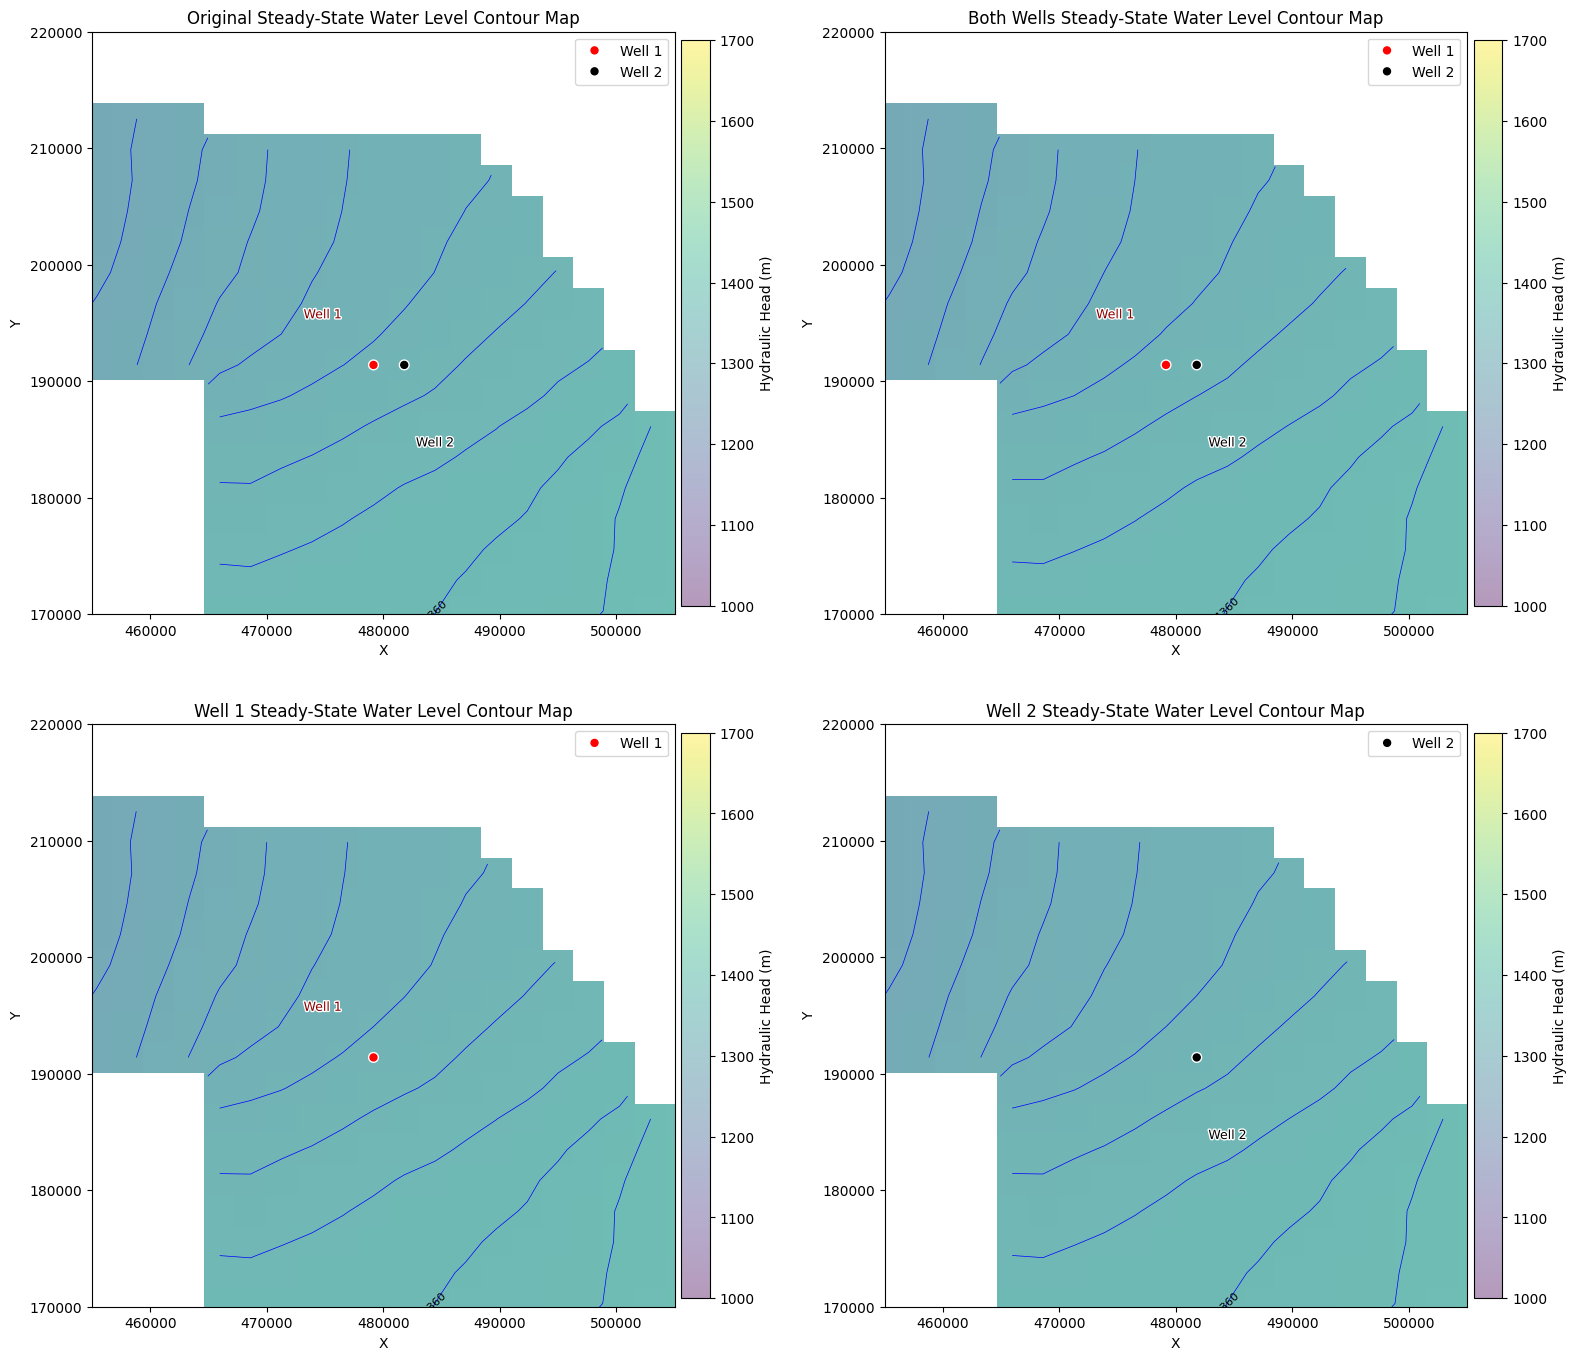

In [ ]:
#plotting different scenarios
def create_contour_maps(m, ax, head, names="Original", contours=True, streamlines=True):
    sp_idx = 78  # -1
    layer = 0 # since we only looking at the first layer

    colors = "RdBu_r"
    if contours:
        colors = "viridis"
        times = head.get_times()
        missing_value = HNOFLO
        # mask_noflow = head <= missing_value
        head = head.get_data(totim=times[sp_idx])[layer]
        head[head <= missing_value] = np.nan

    pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)  # layer 0 = top layer

    # Plot the head contours
    contour_levels = np.arange(np.nanmin(head), np.nanmax(head), 10)
    cs = pmv.contour_array(head, levels=contour_levels, colors="blue", linewidths=0.5)


    # ---- 2) Label contour lines (THIS is what clabel needs) ----
    ax.clabel(
        cs,
        inline=False,      # don't erase the line behind the label
        fontsize=8,
        fmt="%d",          # integer labels
        colors="black"
    )       # Label color

    
    cf = pmv.plot_array(head, alpha=0.4, cmap=colors)

    # ---------------------------
    # 3. Plot your selected well
    # ---------------------------

    mg = m.modelgrid
    xc_raw = np.asarray(mg.xcellcenters)
    yc_raw = np.asarray(mg.ycellcenters)

    # Make sure centers are 2D (nrow, ncol)
    nrow, ncol = mg.nrow, mg.ncol
    if xc_raw.ndim == 1:
        xc = xc_raw.reshape((nrow, ncol))
        yc = yc_raw.reshape((nrow, ncol))
    else:
        xc, yc = xc_raw, yc_raw

    # 2. Well 1 coord
    i_well, j_well = 123, 181
    x0 = xc[i_well, j_well]
    y0 = yc[i_well, j_well]

    # 3. Well 2 Coordinates
    i2_well, j2_well = 123, 182
    xa = xc[i2_well, j2_well]
    yb = yc[i2_well, j2_well]

    # --- Plot wells based on the scenario name ---

    # Plot Well 1 for: Original, Both Wells, Well 1
    if names in ("Original", "Both Wells", "Well 1"):
        ax.plot(x0, y0, "ro", markersize=5, label="Well 1", path_effects=[pe.withStroke(linewidth=3, foreground="white")])
        ax.text(x0 - 6000, y0 + 4000, "Well 1", color="darkred", fontsize=9, path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    # Plot Well 2 for: Original, Both Wells, Well 2
    if names in ("Original", "Both Wells", "Well 2"):
        ax.plot(xa, yb, "ko", markersize=5, label="Well 2", path_effects=[pe.withStroke(linewidth=3, foreground="white")])
        ax.text(xa + 1000, yb - 7000, "Well 2", color="black", fontsize=9, path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    cbar = plt.colorbar(cf, ax=ax, shrink=0.9 if contours else 0.35, pad=0.01)
    cbar.set_label("Hydraulic Head (m)")

    # ---------------------------
    # 4. Finalize plot
    # ---------------------------
    ax.set_title(f"{names} Steady-State Water Level Contour Map")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim(455000,505000)
    ax.set_ylim(170000,220000)
    ax.set_aspect('equal')

    
names = ["Original", "Both Wells", "Well 1", "Well 2"]  

fig, ax = plt.subplots(2, 2, figsize=(16,14))

for m, h, name, axis in zip(models, heads, names, ax.flat):
    create_contour_maps(m, axis, h, name)

plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/quatro_final-period_waterlevel.png", dpi=300)
plt.show()


In [ ]:
drawdown_both = h_both_off - h_baseline
drawdown_w1   = h_well1_off - h_baseline
drawdown_w2   = h_well2_off - h_baseline

print(f"  Well 1 max drawdown: {np.nanmin(drawdown_w1):.3f} ft")
print(f"  Well 2 max drawdown: {np.nanmin(drawdown_w2):.3f} ft")
print(f"  Both max drawdown: {np.nanmin(drawdown_both):.3f} ft")

drawdowns = [drawdown_both, drawdown_w1, drawdown_w2]

  Well 1 max drawdown: -0.234 ft
  Well 2 max drawdown: -0.234 ft
  Both max drawdown: -0.234 ft


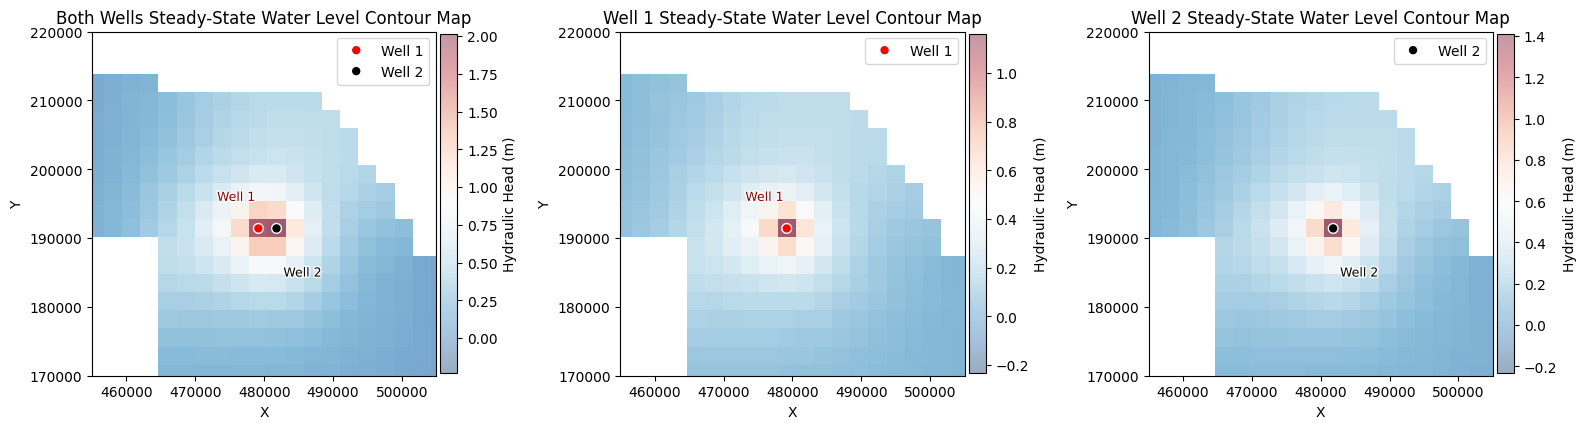

In [ ]:
models2     = [m_02, m_03, m_04]      # 3 scenario models
drawdowns  = [drawdown_both, drawdown_w1, drawdown_w2] # 3 drawdown 2D arrays
names      = ["Both Wells", "Well 1", "Well 2"]

fig, ax = plt.subplots(1, 3, figsize=(16, 10))

for m, dd, name, axis in zip(models2, drawdowns, names, ax.flat):
    create_contour_maps(m, axis, dd, name, contours=False, streamlines=False)

plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/quatro_final-period_drawdown.png", dpi=300)
plt.show()


In [ ]:
# Get stress period times (not individual time steps)
nper = mf.nper
print(f"Number of stress periods: {nper}")
print(f"Number of time steps: {len(times)}")

# Get kstpkper (stress period info)
kstpkper_list = hds_baseline.get_kstpkper()
print(f"Number of kstpkper entries: {len(kstpkper_list)}")

# Extract only the LAST time step of each stress period
sp_times = []
sp_indices = []

for kstpkper in kstpkper_list:
    kstp, kper = kstpkper
    # Only take last time step of each stress period
    if kper not in [k for s, k in sp_indices]:
        sp_indices.append((kstp, kper))
        totim = hds_baseline.get_times()[hds_baseline.get_kstpkper().index(kstpkper)]
        sp_times.append(totim)

print(f"\nStress periods found: {len(sp_indices)}")

Number of stress periods: 194
Number of time steps: 2317
Number of kstpkper entries: 2317

Stress periods found: 194


In [ ]:
hds_baseline.get_kstpkper?

Signature: hds_baseline.get_kstpkper()
Docstring:
Get a list of unique tuples (stress period, time step) in the file.
Indices are 0-based, use the `kstpkper` attribute for 1-based.

Returns
-------
list of (kstp, kper) tuples
    List of unique combinations of stress period &
    time step indices (0-based) in the binary file
File:      ~/.local/lib/python3.11/site-packages/flopy/utils/datafile.py
Type:      method

In [ ]:
# Extract heads at well locations for each STRESS PERIOD (last time step)
n_sp = 194

# Well 1 location
heads_w1_sp = {
    'baseline': np.zeros(n_sp),
    'both_off': np.zeros(n_sp),
    'well1_off': np.zeros(n_sp),
    'well2_off': np.zeros(n_sp)
}

# Well 2 location  
heads_w2_sp = {
    'baseline': np.zeros(n_sp),
    'both_off': np.zeros(n_sp),
    'well1_off': np.zeros(n_sp),
    'well2_off': np.zeros(n_sp)
}

print("Extracting heads at end of each stress period...")
for i, (kstp, kper) in enumerate(sp_indices):
    # Baseline
    h_base = hds_baseline.get_data(kstpkper=(kstp, kper))[layer]
    h_base[h_base <= HNOFLO] = np.nan  # missing_value
    heads_w1_sp['baseline'][i] = h_base[well_1[0], well_1[1]]
    heads_w2_sp['baseline'][i] = h_base[well_2[0], well_2[1]]
    
    # Both off
    h_off = hds_both_off.get_data(kstpkper=(kstp, kper))[layer]
    h_off[h_off <= HNOFLO] = np.nan
    heads_w1_sp['both_off'][i] = h_off[well_1[0], well_1[1]]
    heads_w2_sp['both_off'][i] = h_off[well_2[0], well_2[1]]
    
    # Well 1 off
    h_w1off = hds_well1_off.get_data(kstpkper=(kstp, kper))[layer]
    h_w1off[h_w1off <= HNOFLO] = np.nan
    heads_w1_sp['well1_off'][i] = h_w1off[well_1[0], well_1[1]]
    heads_w2_sp['well1_off'][i] = h_w1off[well_2[0], well_2[1]]
    
    # Well 2 off
    h_w2off = hds_well2_off.get_data(kstpkper=(kstp, kper))[layer]
    h_w2off[h_w2off <= HNOFLO] = np.nan
    heads_w1_sp['well2_off'][i] = h_w2off[well_1[0], well_1[1]]
    heads_w2_sp['well2_off'][i] = h_w2off[well_2[0], well_2[1]]

# Calculate drawdowns
dd_w1_from_well1 = heads_w1_sp['baseline'] - heads_w1_sp['well1_off']
dd_w2_from_well2 = heads_w2_sp['baseline'] - heads_w2_sp['well2_off']

# Find max drawdown
max_dd_w1 = np.nanmax(dd_w1_from_well1)
max_dd_w2 = np.nanmax(dd_w2_from_well2)
sp_max_w1 = np.nanargmax(dd_w1_from_well1)
sp_max_w2 = np.nanargmax(dd_w2_from_well2)

print(f"\n✓ Extracted {n_sp} stress periods")
print(f"\nWell 1:")
print(f"  Max drawdown: {max_dd_w1:.2f} ft at SP {sp_max_w1+1}")
print(f"\nWell 2:")
print(f"  Max drawdown: {max_dd_w2:.2f} ft at SP {sp_max_w2+1}")

Extracting heads at end of each stress period...



✓ Extracted 194 stress periods

Well 1:
  Max drawdown: -0.00 ft at SP 1

Well 2:
  Max drawdown: 0.44 ft at SP 155


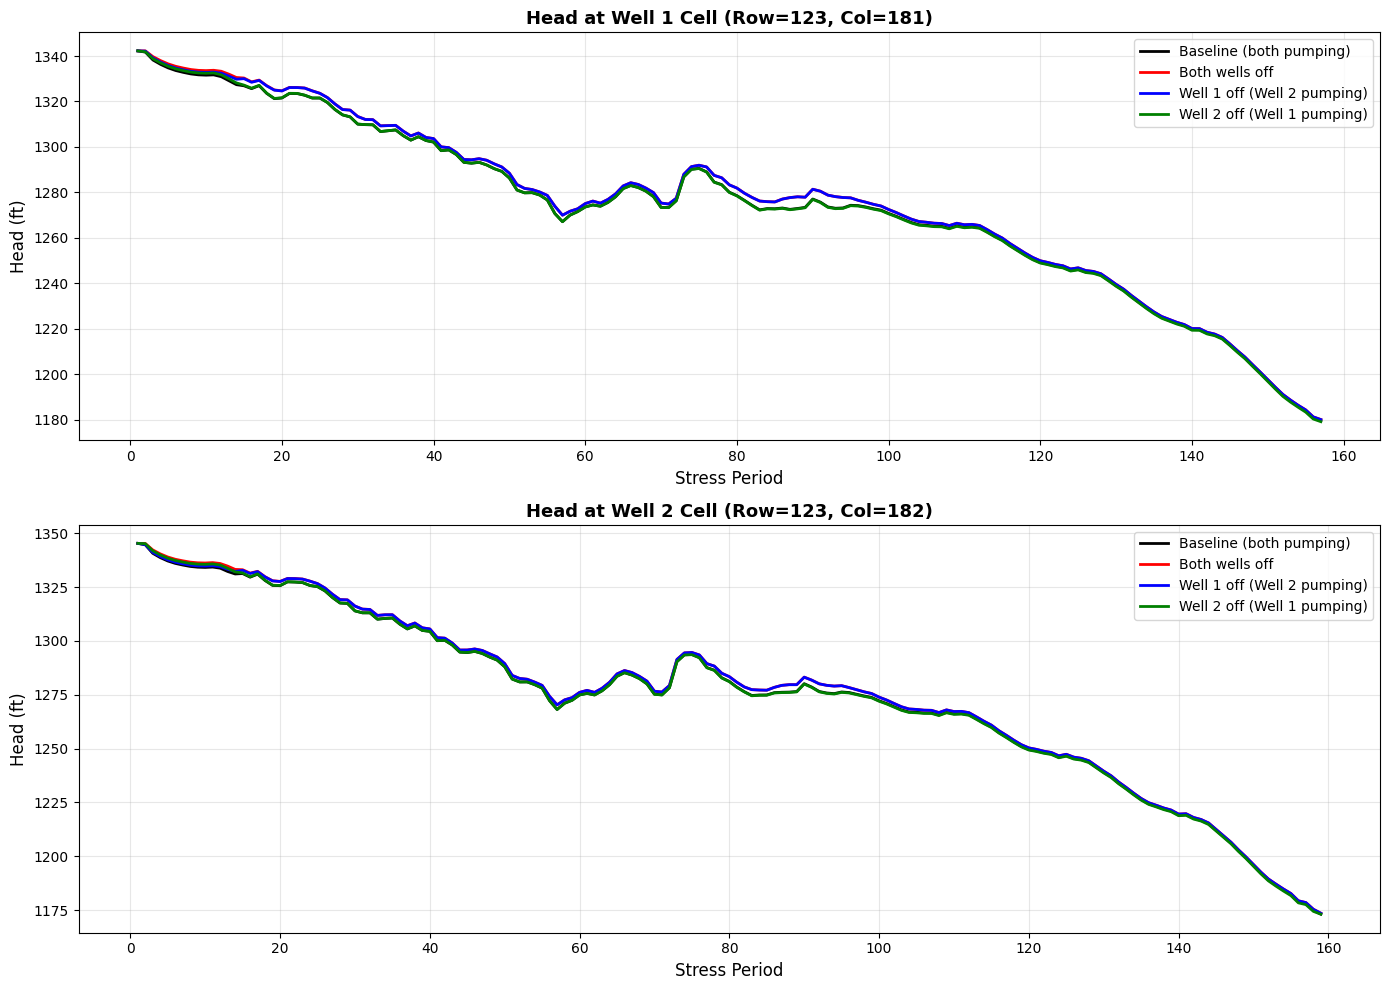


Well 1 max drawdown: -0.00 ft at SP 1
Well 2 max drawdown: 0.44 ft at SP 155


In [ ]:
# Plot time series at both well cells
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Stress period numbers for x-axis
sp_numbers = np.arange(1, n_sp + 1)

# Well 1 cell
ax = axes[0]
ax.plot(sp_numbers, heads_w1_sp['baseline'], 'k-', linewidth=2, label='Baseline (both pumping)')
ax.plot(sp_numbers, heads_w1_sp['both_off'], 'r-', linewidth=2, label='Both wells off')
ax.plot(sp_numbers, heads_w1_sp['well1_off'], 'b-', linewidth=2, label='Well 1 off (Well 2 pumping)')
ax.plot(sp_numbers, heads_w1_sp['well2_off'], 'g-', linewidth=2, label='Well 2 off (Well 1 pumping)')

ax.set_xlabel('Stress Period', fontsize=12)
ax.set_ylabel('Head (ft)', fontsize=12)
ax.set_title(f'Head at Well 1 Cell (Row={well_1[0]}, Col={well_1[1]})', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Well 2 cell
ax = axes[1]
ax.plot(sp_numbers, heads_w2_sp['baseline'], 'k-', linewidth=2, label='Baseline (both pumping)')
ax.plot(sp_numbers, heads_w2_sp['both_off'], 'r-', linewidth=2, label='Both wells off')
ax.plot(sp_numbers, heads_w2_sp['well1_off'], 'b-', linewidth=2, label='Well 1 off (Well 2 pumping)')
ax.plot(sp_numbers, heads_w2_sp['well2_off'], 'g-', linewidth=2, label='Well 2 off (Well 1 pumping)')

ax.set_xlabel('Stress Period', fontsize=12)
ax.set_ylabel('Head (ft)', fontsize=12)
ax.set_title(f'Head at Well 2 Cell (Row={well_2[0]}, Col={well_2[1]})', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)


plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/duo_final-period_hdsvtime.png", dpi=300)
plt.show()

print(f"\nWell 1 max drawdown: {max_dd_w1:.2f} ft at SP {sp_max_w1+1}")
print(f"Well 2 max drawdown: {max_dd_w2:.2f} ft at SP {sp_max_w2+1}")

Using totim = 70493.5390625 (index -1)
qx min/max: -inf inf
qy min/max: -inf inf


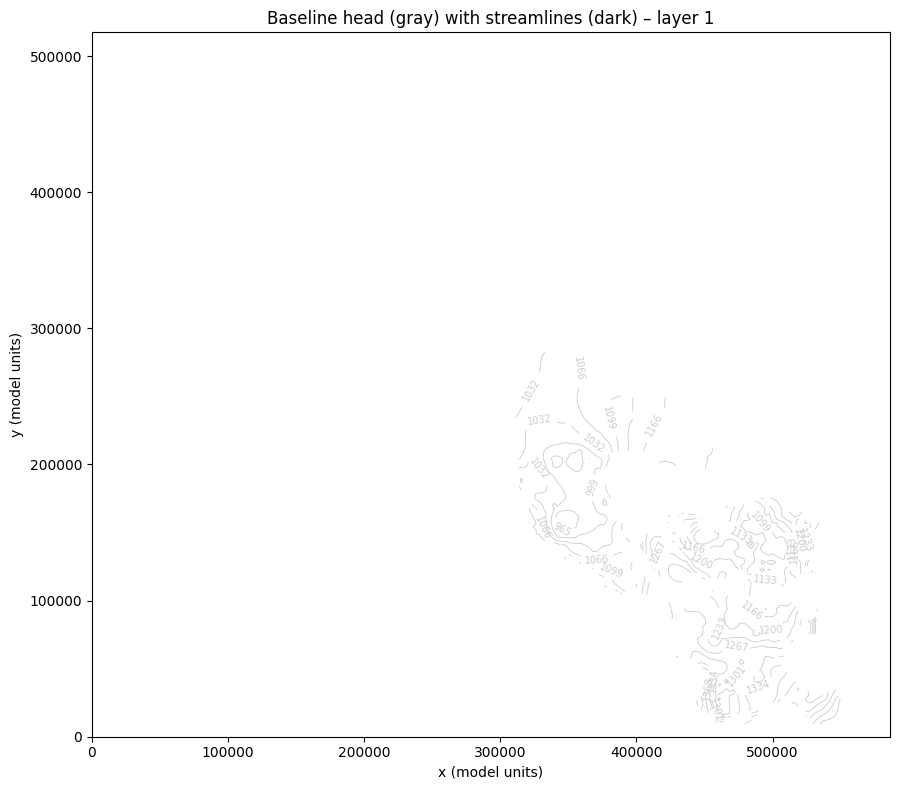

In [ ]:
sp_idx_stream = -1
layer_stream = 0
totim_stream = times[sp_idx_stream]

print(f"Using totim = {totim_stream} (index {sp_idx_stream})")

# --- Heads ---
head_3d = hds_baseline.get_data(totim=totim_stream)
head = head_3d[layer_stream, :, :].astype(float)
head[head <= HNOFLO] = np.nan

# --- K & grid ---
hk = mf.lpf.hk.array[layer_stream, :, :].astype(float)
delr = mf.dis.delr.array
delc = mf.dis.delc.array

# --- Gradients & q ---
dhdy, dhdx = np.gradient(head, delc, delr)
qx = -hk * dhdx
qy = -hk * dhdy

qx[head <= HNOFLO] = np.nan
qy[head <= HNOFLO] = np.nan

print("qx min/max:", np.nanmin(qx), np.nanmax(qx))
print("qy min/max:", np.nanmin(qy), np.nanmax(qy))

x, y = mf.modelgrid.xcellcenters, mf.modelgrid.ycellcenters
y = -y

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect("equal")

pmv = flopy.plot.PlotMapView(model=mf, layer=layer_stream, ax=ax)

# 1) HEAD CONTOURS: light background
levels = np.linspace(np.nanmin(head), np.nanmax(head), 20)
cs = pmv.contour_array(head, levels=levels, colors="0.8", linewidths=0.6)
ax.clabel(cs, inline=True, fontsize=7, fmt="%.0f")

# 2) STREAMLINES: darker, thicker, with arrows
strm = ax.streamplot(
    x,
    y,
    qx,
    qy,
    density=2.5,
    linewidth=1.2,   # a bit thicker
    arrowsize=1.5,   # more obvious arrows
    zorder=5,
)

ax.set_title("Baseline head (gray) with streamlines (dark) – layer 1")
ax.set_xlabel("x (model units)")
ax.set_ylabel("y (model units)")

# While debugging, let autoscale; comment out any xlim/ylim for now
# ax.set_xlim(280000, 580000)
# ax.set_ylim(0, 300000)

plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/final-period_streamflow.png", dpi=300)
plt.show()
